In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from faster_rcnn.utils.datasets.voc.voc import VOCDetection
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from faster_rcnn.utils.datasets.data_generator import CocoGenerator
from faster_rcnn.utils.datasets.data_generator import Enqueuer
from torch.optim import SGD, RMSprop, Adam

from faster_rcnn.faster_rcnn import FasterRCNN
from pycrayon import CrayonClient
import torch
from torch.optim.lr_scheduler import StepLR
from datetime import datetime
from PIL import Image, ImageDraw, ImageFont


/data
/data/data/mscoco


In [3]:
root = '/data'
ds = VOCDetection(root, 'train')
print(len(ds))

320


In [4]:
def imshow(inp, gt_boxes=[], predict_boxes = []):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig,ax = plt.subplots(1, figsize=(20, 10))

    ax.imshow(inp)
    for i, box in enumerate(gt_boxes):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1]  ,linewidth=2,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        
    for i, box in enumerate(predict_boxes):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1]  ,linewidth=1,edgecolor='g',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.pause(0.001)  # pause a bit so that plots are updated


In [5]:
data_gen = CocoGenerator(data=ds, batch_size=1)
queue = Enqueuer(generator=data_gen, use_multiprocessing=False)
queue.start(max_queue_size=100, workers=10)


In [6]:
t = queue.get()

[3 3 3]


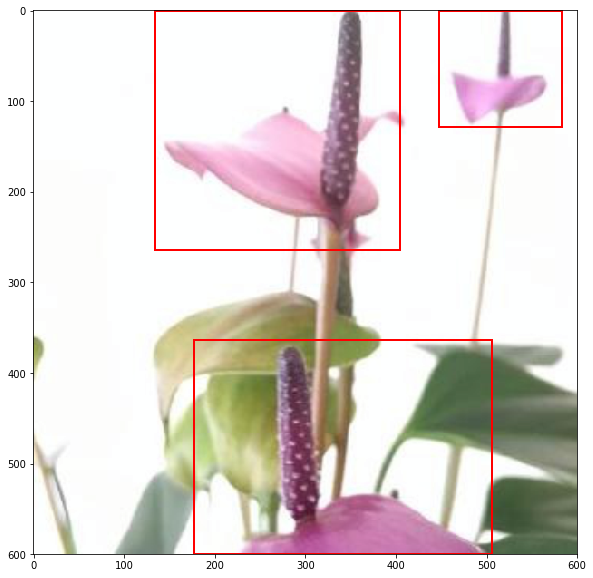

In [32]:
blobs = t.next()
gt_boxes = blobs['boxes']
gt_classes = blobs['gt_classes']
print(gt_classes)
imshow(blobs['tensor'][0], gt_boxes)

In [33]:
categories = ds.classes
print(categories)

['__background__', u'860', u'80', u'82']


In [9]:
net = FasterRCNN(categories, debug=False)
net.cuda()
net.train()

FasterRCNN(
  (roi_pool): RoIPool(
  )
  (fc6): FC(
    (fc): Linear(in_features=25088, out_features=4096)
    (relu): ReLU(inplace)
  )
  (fc7): FC(
    (fc): Linear(in_features=4096, out_features=4096)
    (relu): ReLU(inplace)
  )
  (score_fc): FC(
    (fc): Linear(in_features=4096, out_features=4)
  )
  (bbox_fc): FC(
    (fc): Linear(in_features=4096, out_features=16)
  )
  (rpn): RPN(
    (features): Sequential(
      (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (10): Conv2d

In [10]:
param = filter(lambda x: x.requires_grad, net.parameters())

In [11]:
def train(data_gen, optimizer, lr_scheduler ,model, epochs, steps_per_epoch):
    exp_name = datetime.now().strftime('vgg16_%m-%d_%H-%M')
    cc = CrayonClient(hostname="crayon", port=8889)
    exp = cc.create_experiment(exp_name)
    model.train()
    train_loss = 0

    for epoch in range(epochs):
        for step in range(1, steps_per_epoch +1):
            lr_scheduler.step()
            try:
                blobs = data_gen.next()
                im_data = blobs['tensor']
                im_info = blobs['im_info']
                gt_boxes = blobs['boxes']
                gt_classes = blobs['gt_classes']
                gt_boxes = np.hstack([gt_boxes , gt_classes[:, np.newaxis]])
                cls_prob, bbox_pred, rois = model(im_data, im_info, gt_boxes)
            except Exception as e:
                print e
                continue
                
            loss = model.loss
            train_loss += loss.data[0]
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if step % 10 == 0:
                log_text = 'step %d, image: %s, loss: %.4f' % (
                    step, blobs['im_name'], train_loss /(step))
                print(log_text)

                re_cnt = True

            if step % 400 == 0:
                torch.save(model.state_dict(), 'faster_model_at_step_%s.pkl' % step)

In [12]:
optimizer = SGD(param, lr=1e-4, momentum=0.9, weight_decay=0.0005)
exp_lr_scheduler = StepLR(optimizer, step_size=1000, gamma=0.95)

In [34]:
train(t, optimizer=optimizer,lr_scheduler=exp_lr_scheduler, model=net, epochs=1, steps_per_epoch=2000)

step 10, image: 1515601693827_thum_1515601692666_thum_photo.jpg, loss: 0.4471
step 20, image: 1516323555844_thum_1516323555380_thum_photo.jpg, loss: 0.4619
step 30, image: 1467272399386_thum_1467272398968_thum_tmp.jpg, loss: 0.7209
step 40, image: 1497798844603_thum_1497798844181_thum_sample.jpg, loss: 0.7807
step 50, image: 1513155376081_thum_1513155375594_thum_photo.jpg, loss: 0.8557
step 60, image: 1513326252081_thum_1513326251419_thum_photo.jpg, loss: 0.8584
step 70, image: 1513549796371_thum_1513549795564_thum_photo.jpg, loss: 0.8193
step 80, image: 1513788579211_thum_1513788578721_thum_photo.jpg, loss: 0.7721
step 90, image: 1513895678786_thum_1513895678318_thum_photo.jpg, loss: 0.7390
step 100, image: 1514005336991_thum_1514005336548_thum_photo.jpg, loss: 0.7014
step 110, image: 1514126473908_thum_1514126473501_thum_sample.jpg, loss: 0.6761
step 120, image: 1514349197845_thum_1514349197235_thum_photo.jpg, loss: 0.6639
step 130, image: 1514603558674_thum_1514603558324_thum_sample

INFO:faster_rcnn.utils.datasets.voc.voc:[Errno 2] No such file or directory: '/data/VOC2007/JPEGImages/1504793143551_thum_1504793045495_thum_P1120074.jpg'
INFO:faster_rcnn.utils.datasets.voc.voc:[Errno 2] No such file or directory: '/data/VOC2007/JPEGImages/1504793143551_thum_1504793045495_thum_P1120074.jpg'


step 210, image: 1493162334980_thum_1493162333337_thum_photo.jpg, loss: 0.6487


INFO:faster_rcnn.utils.datasets.voc.voc:[Errno 2] No such file or directory: '/data/VOC2007/Annotations/1513834408994_thum_1513833919412_thum_PC170267.xml'
INFO:faster_rcnn.utils.datasets.voc.voc:[Errno 2] No such file or directory: '/data/VOC2007/Annotations/1513834408994_thum_1513833919412_thum_PC170267.xml'


step 220, image: 1494624925768_thum_1494624925267_thum_photo.jpg, loss: 0.6559
step 230, image: 1496743812023_thum_1496743811391_thum_photo.jpg, loss: 0.6556
step 240, image: 1497278926877_thum_1497278926033_thum_photo.jpg, loss: 0.6535
step 250, image: 1499128504961_thum_1499128504300_thum_photo.jpg, loss: 0.6507
step 260, image: 1499933604151_thum_1499933603595_thum_photo.jpg, loss: 0.6417
step 270, image: 1501300468953_thum_1501300468583_thum_sample.jpg, loss: 0.6392
step 280, image: 1501333823444_thum_1501333823152_thum_sample.jpg, loss: 0.6390
step 290, image: 1502839816593_thum_1502839816257_thum_sample.jpg, loss: 0.6370
step 300, image: 1506856076230_thum_1506856075187_thum_photo.jpg, loss: 0.6310
step 310, image: 1508423484236_thum_1508423483620_thum_photo.jpg, loss: 0.6260
step 320, image: 1513137839518_thum_1513137839114_thum_sample.jpg, loss: 0.6212
step 330, image: 1515034815446_thum_1515034814905_thum_photo.jpg, loss: 0.6173
step 340, image: 1439866445752_thum_143986644408

INFO:faster_rcnn.utils.datasets.voc.voc:[Errno 2] No such file or directory: '/data/VOC2007/JPEGImages/1504793143551_thum_1504793045495_thum_P1120074.jpg'
INFO:faster_rcnn.utils.datasets.voc.voc:[Errno 2] No such file or directory: '/data/VOC2007/JPEGImages/1504793143551_thum_1504793045495_thum_P1120074.jpg'


step 520, image: 1490202029700_thum_1490202029150_thum_tmp.jpg, loss: 0.6118
step 530, image: 1494232497469_thum_1494232497114_thum_photo.jpg, loss: 0.6218


INFO:faster_rcnn.utils.datasets.voc.voc:[Errno 2] No such file or directory: '/data/VOC2007/Annotations/1513834408994_thum_1513833919412_thum_PC170267.xml'
INFO:faster_rcnn.utils.datasets.voc.voc:[Errno 2] No such file or directory: '/data/VOC2007/Annotations/1513834408994_thum_1513833919412_thum_PC170267.xml'


step 540, image: 1494624925768_thum_1494624925267_thum_photo.jpg, loss: 0.6222
step 550, image: 1496132014108_thum_1496132013493_thum_photo.jpg, loss: 0.6219
step 560, image: 1496720205020_thum_1496720204452_thum_photo.jpg, loss: 0.6214
step 570, image: 1499343361002_thum_1499343360559_thum_sample.jpg, loss: 0.6206
step 580, image: 1499344566777_thum_1499344566195_thum_photo.jpg, loss: 0.6191
step 590, image: 1501300468953_thum_1501300468583_thum_sample.jpg, loss: 0.6181
step 600, image: 1501546173768_thum_1501546173393_thum_photo.jpg, loss: 0.6176
step 610, image: 1503734596070_thum_1503734595741_thum_sample.jpg, loss: 0.6157
step 620, image: 1507512502096_thum_1507512501529_thum_photo.jpg, loss: 0.6138
step 630, image: 1510672281680_thum_1510672281237_thum_sample.jpg, loss: 0.6126
step 640, image: 1512985725740_thum_1512985725156_thum_photo.jpg, loss: 0.6100
step 650, image: 1501289618157_thum_1501289617411_thum_photo.jpg, loss: 0.6079
step 660, image: 1445652217133_thum_144565221603

INFO:faster_rcnn.utils.datasets.voc.voc:[Errno 2] No such file or directory: '/data/VOC2007/JPEGImages/1504793143551_thum_1504793045495_thum_P1120074.jpg'
INFO:faster_rcnn.utils.datasets.voc.voc:[Errno 2] No such file or directory: '/data/VOC2007/JPEGImages/1504793143551_thum_1504793045495_thum_P1120074.jpg'


step 840, image: 1492057246728_thum_1492057246213_thum_photo.jpg, loss: 0.6032
step 850, image: 1492517995145_thum_1492517994042_thum_photo.jpg, loss: 0.6073


INFO:faster_rcnn.utils.datasets.voc.voc:[Errno 2] No such file or directory: '/data/VOC2007/Annotations/1513834408994_thum_1513833919412_thum_PC170267.xml'
INFO:faster_rcnn.utils.datasets.voc.voc:[Errno 2] No such file or directory: '/data/VOC2007/Annotations/1513834408994_thum_1513833919412_thum_PC170267.xml'


step 860, image: 1494474302018_thum_1494474301430_thum_photo.jpg, loss: 0.6075
step 870, image: 1496743656940_thum_1496743656083_thum_photo.jpg, loss: 0.6073
step 880, image: 1497308505089_thum_1497308504746_thum_photo.jpg, loss: 0.6063
step 890, image: 1499343361002_thum_1499343360559_thum_sample.jpg, loss: 0.6055
step 900, image: 1501288083593_thum_1501288083098_thum_sample.jpg, loss: 0.6045
step 910, image: 1501326316967_thum_1501326316606_thum_sample.jpg, loss: 0.6044
step 920, image: 1502073075786_thum_1502073075474_thum_photo.jpg, loss: 0.6036
step 930, image: 1503754703037_thum_1503754702560_thum_sample.jpg, loss: 0.6026
step 940, image: 1506208469802_thum_1506208469389_thum_photo.jpg, loss: 0.6019
step 950, image: 1508905503878_thum_1508905503408_thum_photo.jpg, loss: 0.5999
step 960, image: 1499775985963_thum_1499775983529_thum_photo.jpg, loss: 0.5984
step 970, image: 1515918119932_thum_1515918119233_thum_photo.jpg, loss: 0.5970
step 980, image: 1473488549033_thum_147348854876

INFO:faster_rcnn.utils.datasets.voc.voc:[Errno 2] No such file or directory: '/data/VOC2007/JPEGImages/1504793143551_thum_1504793045495_thum_P1120074.jpg'
INFO:faster_rcnn.utils.datasets.voc.voc:[Errno 2] No such file or directory: '/data/VOC2007/JPEGImages/1504793143551_thum_1504793045495_thum_P1120074.jpg'


step 1150, image: 1513120816895_thum_1513120816150_thum_photo.jpg, loss: 0.5898
step 1160, image: 1492057246728_thum_1492057246213_thum_photo.jpg, loss: 0.5970
step 1170, image: 1494624925768_thum_1494624925267_thum_photo.jpg, loss: 0.5982


INFO:faster_rcnn.utils.datasets.voc.voc:[Errno 2] No such file or directory: '/data/VOC2007/Annotations/1513834408994_thum_1513833919412_thum_PC170267.xml'
INFO:faster_rcnn.utils.datasets.voc.voc:[Errno 2] No such file or directory: '/data/VOC2007/Annotations/1513834408994_thum_1513833919412_thum_PC170267.xml'


step 1180, image: 1496014774702_thum_1496014774351_thum_sample.jpg, loss: 0.5981
step 1190, image: 1497008695324_thum_1497008694775_thum_photo.jpg, loss: 0.5979
step 1200, image: 1498592065054_thum_1498592064643_thum_photo.jpg, loss: 0.5965
step 1210, image: 1499933604151_thum_1499933603595_thum_photo.jpg, loss: 0.5963
step 1220, image: 1501288083593_thum_1501288083098_thum_sample.jpg, loss: 0.5948
step 1230, image: 1501326316967_thum_1501326316606_thum_sample.jpg, loss: 0.5947
step 1240, image: 1501746242191_thum_1501746241589_thum_photo.jpg, loss: 0.5940
step 1250, image: 1503754703037_thum_1503754702560_thum_sample.jpg, loss: 0.5928
step 1260, image: 1506988555968_thum_1506988555526_thum_sample.jpg, loss: 0.5917
step 1270, image: 1506861165400_thum_1506861164739_thum_photo.jpg, loss: 0.5903
step 1280, image: 1501289618157_thum_1501289617411_thum_photo.jpg, loss: 0.5885
step 1290, image: 1500101406450_thum_1500101405597_thum_photo.jpg, loss: 0.5873
step 1300, image: 1463441075372_thu

INFO:faster_rcnn.utils.datasets.voc.voc:[Errno 2] No such file or directory: '/data/VOC2007/JPEGImages/1504793143551_thum_1504793045495_thum_P1120074.jpg'
INFO:faster_rcnn.utils.datasets.voc.voc:[Errno 2] No such file or directory: '/data/VOC2007/JPEGImages/1504793143551_thum_1504793045495_thum_P1120074.jpg'


step 1470, image: 1490377786997_thum_1490377786525_thum_photo.jpg, loss: 0.5823
step 1480, image: 1493722105308_thum_1493722104739_thum_photo.jpg, loss: 0.5853
step 1490, image: 1495079443446_thum_1495079442948_thum_sample.jpg, loss: 0.5861


INFO:faster_rcnn.utils.datasets.voc.voc:[Errno 2] No such file or directory: '/data/VOC2007/Annotations/1513834408994_thum_1513833919412_thum_PC170267.xml'
INFO:faster_rcnn.utils.datasets.voc.voc:[Errno 2] No such file or directory: '/data/VOC2007/Annotations/1513834408994_thum_1513833919412_thum_PC170267.xml'


step 1500, image: 1496782797760_thum_1496782797369_thum_photo.jpg, loss: 0.5860
step 1510, image: 1497008695324_thum_1497008694775_thum_photo.jpg, loss: 0.5859
step 1520, image: 1495661338866_thum_1495661338407_thum_tmp.jpg, loss: 0.5853
step 1530, image: 1499832335706_thum_1499832334971_thum_photo.jpg, loss: 0.5848
step 1540, image: 1501298843645_thum_1501298843152_thum_photo.jpg, loss: 0.5846
step 1550, image: 1501283046425_thum_1501283045850_thum_photo.jpg, loss: 0.5839
step 1560, image: 1502926740187_thum_1502926739868_thum_sample.jpg, loss: 0.5832
step 1570, image: 1505659867949_thum_1505659867425_thum_photo.jpg, loss: 0.5827
step 1580, image: 1507042548739_thum_1507042548228_thum_sample.jpg, loss: 0.5816
step 1590, image: 1510672403262_thum_1510672402844_thum_sample.jpg, loss: 0.5804
step 1600, image: 1498812249831_thum_1498812249279_thum_photo.jpg, loss: 0.5796
step 1610, image: 1516077132588_thum_1516077131654_thum_photo.jpg, loss: 0.5783
step 1620, image: 1473488549033_thum_14

INFO:faster_rcnn.utils.datasets.voc.voc:[Errno 2] No such file or directory: '/data/VOC2007/JPEGImages/1504793143551_thum_1504793045495_thum_P1120074.jpg'
INFO:faster_rcnn.utils.datasets.voc.voc:[Errno 2] No such file or directory: '/data/VOC2007/JPEGImages/1504793143551_thum_1504793045495_thum_P1120074.jpg'


step 1780, image: 1515641591724_thum_1515641591184_thum_photo.jpg, loss: 0.5714
step 1790, image: 1490202029700_thum_1490202029150_thum_tmp.jpg, loss: 0.5732
step 1800, image: 1492517995145_thum_1492517994042_thum_photo.jpg, loss: 0.5755


INFO:faster_rcnn.utils.datasets.voc.voc:[Errno 2] No such file or directory: '/data/VOC2007/Annotations/1513834408994_thum_1513833919412_thum_PC170267.xml'
INFO:faster_rcnn.utils.datasets.voc.voc:[Errno 2] No such file or directory: '/data/VOC2007/Annotations/1513834408994_thum_1513833919412_thum_PC170267.xml'


step 1810, image: 1495511502491_thum_1495511501860_thum_tmp.jpg, loss: 0.5758
step 1820, image: 1496782797760_thum_1496782797369_thum_photo.jpg, loss: 0.5756
step 1830, image: 1497351329079_thum_1497351328349_thum_photo.jpg, loss: 0.5754
step 1840, image: 1499128504961_thum_1499128504300_thum_photo.jpg, loss: 0.5749
step 1850, image: 1500719335675_thum_1500719335308_thum_sample.jpg, loss: 0.5747
step 1860, image: 1501300468953_thum_1501300468583_thum_sample.jpg, loss: 0.5741
step 1870, image: 1501333823444_thum_1501333823152_thum_sample.jpg, loss: 0.5737
step 1880, image: 1501746242191_thum_1501746241589_thum_photo.jpg, loss: 0.5730
step 1890, image: 1506856076230_thum_1506856075187_thum_photo.jpg, loss: 0.5721
step 1900, image: 1512516749858_thum_1512516749453_thum_photo.jpg, loss: 0.5713
step 1910, image: 1513428446164_thum_1513428445445_thum_photo.jpg, loss: 0.5701
step 1920, image: 1515034815446_thum_1515034814905_thum_photo.jpg, loss: 0.5693
step 1930, image: 1502003056946_thum_15

In [35]:
def result_show(inp, predicted_boxes=[], classes=[], scores=[]):
    font = ImageFont.truetype(font ='./font/FiraMono-Medium.otf', size=np.floor(3e-2 * 600 + 0.5).astype('int32'))
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    inp *= 255.0/inp.max() 
    
    fig,ax = plt.subplots(1, figsize=(20, 10))
    
    image = Image.fromarray(inp.astype('uint8'))
    
    draw = ImageDraw.Draw(image)
    for predicted_box, predicted_class, score in zip(predicted_boxes, classes, scores):
        label = '{} {:.2f}'.format(predicted_class, score)

        
        label_size = draw.textsize(label, font)
        
        left, top, right, bottom = predicted_box
        print(predicted_class, (left, top), (right, bottom))
        
        for i in range(3):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i],
                outline=(255,255,0))
        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])
        draw.rectangle(
                [tuple(text_origin), tuple(text_origin + label_size)])
        draw.text(text_origin, label, fill=(255, 255, 0), font=font)
    del draw
    ax.imshow(image)

In [36]:
pred_boxes, scores, classes, rois, blob = net.detect('./6.jpg', thr=0.95)

(u'860', (0.0, 11.838499827784709), (236.95690797542829, 137.6492968708981))
(u'860', (273.46441559178777, 371.43059077319504), (599.0, 590.58142636828825))
(u'860', (295.90367850922303, 0.0), (599.0, 336.95411548149167))
(u'860', (4.8001608673647809, 0.0), (231.5288565615418, 599.0))
(u'860', (76.451057160713844, 120.37072405460285), (354.16711852984326, 346.68888832771188))


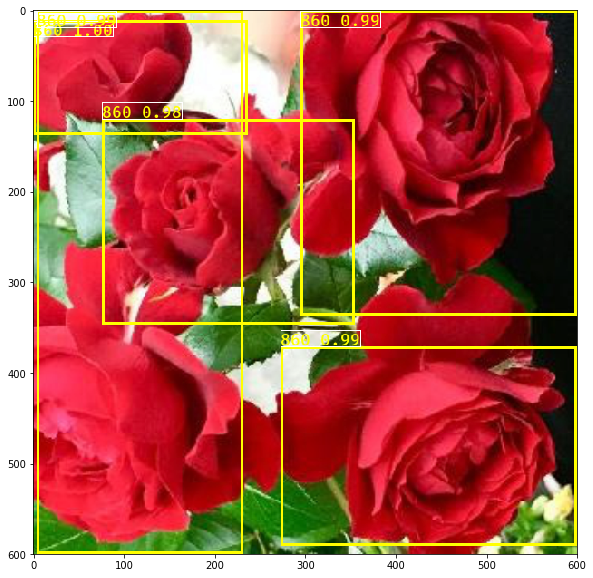

In [37]:
result_show(blob[0], pred_boxes, classes, scores)